# **Podcast Listening Data Analysis**

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Data Loading and Cleaning**
In this step, we import the three datasets that contain all the relevant information needed for our analysis. I use pandas functions read_csv and read_json to load these files into DataFrames so we can manipulate and analyze them easily in Python.

In [7]:
df_e=pd.read_csv('/content/episodes.csv')
df_e

,episode_id,title,category
0,1,Episode 1,Religion
1,2,Episode 2,Technology
2,3,Episode 3,Society
3,4,Episode 4,News
4,5,Episode 5,Politics
5,6,Episode 6,Society
6,7,Episode 7,Religion
7,8,Episode 8,Sports
8,9,Episode 9,Sports
9,10,Episode 10,News


In [8]:
df_u=pd.read_csv('/content/users.csv')
df_u

,user_id,age,gender,country
0,1,38,female,Morocco
1,2,30,female,Jordan
2,3,42,male,Saudi Arabia
3,4,57,female,Egypt
4,5,51,female,Jordan
5,6,59,male,Morocco
6,7,30,male,Egypt
7,8,45,female,Jordan
8,9,43,female,Egypt
9,10,44,male,Jordan


In [45]:
df_l=pd.read_json('/content/listens.json')
df_l

,user_id,episode_id,duration_seconds
0,16,30,60
1,6,8,120
2,6,13,60
3,6,27,1500
4,17,9,1500
...,...,...,...
95,16,28,900
96,19,9,60
97,12,2,1500
98,1,1,1800


Once the datasets are loaded, it’s important to assess data quality by identifying any missing or null values in key columns. Missing data can cause errors or inaccuracies during analysis. I checked the number of missing values in these datasets. This allows us to understand where the data is incomplete and decide how to clean it before further processing.

In [24]:
print("Missing values:\n")
print("Episodes:\n", df_e.isnull().sum())
print("Users:\n", df_u.isnull().sum())
print("Listens:\n", df_l.isnull().sum())

Missing values:

Episodes:
 episode_id    0
title         0
category      0
dtype: int64
Users:
 user_id    0
age        0
gender     0
country    0
dtype: int64
Listens:
 user_id             0
episode_id          0
duration_seconds    0
dtype: int64


In [25]:
df_e.dropna(subset=['episode_id', 'title'], inplace=True)
df_u.dropna(subset=['user_id', 'age'], inplace=True)
df_l.dropna(subset=['user_id', 'episode_id', 'duration_seconds'], inplace=True)

To ensure reliable analysis, we should remove rows with missing critical information that would make the records invalid or unusable. For episodes, any rows without an episode ID or title are dropped, because these are necessary to identify episodes. For users, rows missing user ID or age are removed, as age filtering and user matching depend on these fields. For listens, missing user ID, episode ID, or listening duration rows are dropped because these are essential for linking listens to users and episodes and for analyzing engagement. We also filter users to keep only those with ages between 10 and 100, excluding unrealistic age values that might be data entry errors.

After removing invalid rows, the DataFrames have gaps in their row indexes. Resetting the indexes reassigns sequential numbering starting at zero, which is important for keeping data clean and avoiding confusion during merging or further operations. It helps maintain consistent and orderly data structure.


In [26]:
df_u = df_u[(df_u['age'] >= 10) & (df_u['age'] <= 100)]

df_e.reset_index(drop=True, inplace=True)
df_u.reset_index(drop=True, inplace=True)
df_l.reset_index(drop=True, inplace=True)

  I combined the cleaned datasets to create a unified DataFrame containing all the relevant information for each listening event. First, listens are merged with users on user_id, linking listening behavior with user demographics. Then, this combined data is merged with episodes on episode_id, adding episode details to each listen record. The merges use inner joins, so only records present in both datasets are kept, ensuring complete information for all rows. This final merged DataFrame forms the basis for all subsequent analysis.


In [27]:
df_merged = pd.merge(df_l, df_u, on='user_id', how='inner')

df_merged = pd.merge(df_merged, df_e, on='episode_id', how='inner')
df_merged.head()

,user_id,episode_id,duration_seconds,age,gender,country,title,category
0,16,30,60,24,female,Saudi Arabia,Episode 30,Sports
1,6,8,120,59,male,Morocco,Episode 8,Sports
2,6,13,60,59,male,Morocco,Episode 13,Society
3,6,27,1500,59,male,Morocco,Episode 27,News
4,17,9,1500,21,male,Saudi Arabia,Episode 9,Sports


# **Exploratory Data Analysis**

To understand user engagement, I calculated the average number of unique episodes that each user listens to. We group the merged data by user_id, count how many distinct episodes each user has listened to, then compute the overall average. This metric helps measure how broadly users explore different episodes rather than repeatedly listening to the same ones.


In [32]:
avg_per_user = df_merged.groupby('user_id')['episode_id'].nunique().mean()
print(f"Average episodes per user: {avg_per_user:.2f}")

Average episodes per user: 5.00


I want to explore whether listening habits differ between male and female users. By grouping the data by gender and calculating the mean listening duration in seconds, we can compare average engagement time for each group. This gives insight into potential behavioral differences and can inform targeted content or marketing strategies.



In [57]:
gender_avg = df_merged.groupby("gender")["duration_seconds"].mean()
print("\nAverage Listening Duration by Gender:\n")
print(gender_avg)


Average Listening Duration by Gender:

gender
female    753.962264
male      573.191489
Name: duration_seconds, dtype: float64


This bar chart illustrates the popularity of different podcast categories based on the total number of listens. It is clear that the categories Society and Sports dominate in terms of listener interest, with significantly higher counts compared to News, Religion, and Politics. This indicates that listeners prefer content related to social issues and sports over the other categories shown, which can inform content creators and marketers about audience preferences.

Top Categories by Listening Count:

category
Society     32
Sports      30
News        16
Religion    10
Politics     7
Name: count, dtype: int64


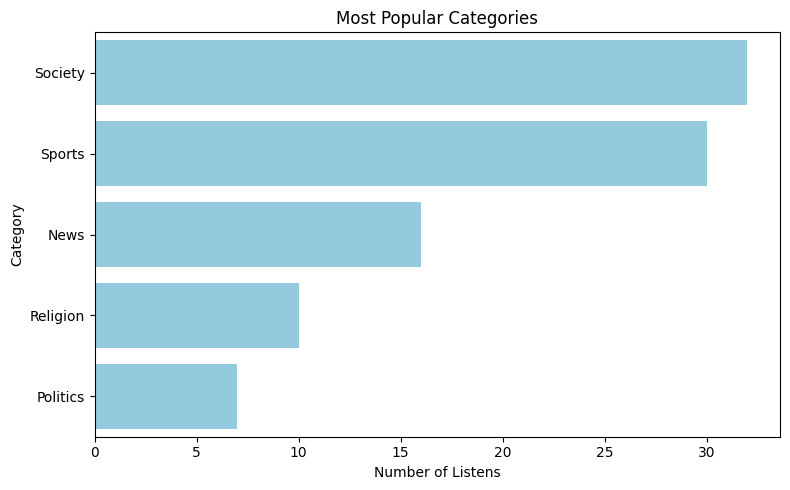

In [59]:
top_categories = df_merged["category"].value_counts().head(5)
print("Top Categories by Listening Count:\n")
print(top_categories)

plt.figure(figsize=(8, 5))
sns.countplot(data=df_merged, y="category", order=top_categories.index, color="skyblue")
plt.title("Most Popular Categories")
plt.xlabel("Number of Listens")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

The boxplot compares listening durations between male and female users, measured in seconds. On average, females tend to listen longer than males. The boxes represent the interquartile range, showing where the middle 50% of listening durations lie, while the whiskers display the range of data excluding outliers. Both genders show a wide variation in listening times, indicating diverse engagement levels within each group.

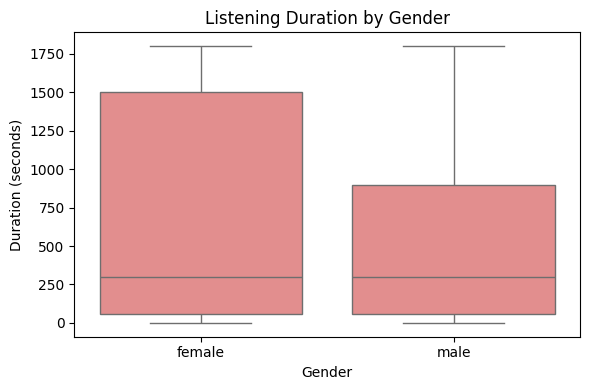

In [58]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_merged, x="gender", y="duration_seconds", color="lightcoral")
plt.title("Listening Duration by Gender")
plt.xlabel("Gender")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()


# **Recommendation System**

I defined a function to recommend new episodes to a user based on their past listening habits. The function first extracts the user’s listening history and identifies their favorite episode categories by mode (most frequently listened category). Then, it finds episodes in those favorite categories that the user hasn’t listened to yet and returns the top three as recommendations. If the user has no history or favorite categories, it randomly recommends three episodes. This approach personalizes recommendations and encourages users to explore new content within their interests.



In [61]:
def recommend_episodes(user_id, listens_df, episodes_df):
    history = listens_df[listens_df["user_id"] == user_id]
    if history.empty:
        return episodes_df.sample(3)[["episode_id", "title"]]

    favorites = history.merge(episodes_df, on="episode_id")
    favorite_categories = favorites["category"].mode()

    if favorite_categories.empty:
        return episodes_df.sample(3)[["episode_id", "title"]]

    unseen = episodes_df[~episodes_df["episode_id"].isin(history["episode_id"])]
    suggestions = unseen[unseen["category"].isin(favorite_categories)]

    return suggestions[["episode_id", "title"]].head(3)

print("\nRecommended Episodes for User 1:\n")
print(recommend_episodes(1, df_l, df_e))



Recommended Episodes for User 1:

    episode_id       title
8            9   Episode 9
10          11  Episode 11
11          12  Episode 12



# **Conclusion**
The analysis of the podcast listening data reveals clear trends in user behavior and preferences. The categories of Society and Sports dominate listener interest, suggesting that content creators should focus on producing more episodes in these genres to meet demand. Furthermore, females tend to listen for longer durations than males, indicating an opportunity to tailor content or marketing strategies by gender. Since users listen to a variety of episodes on average, providing personalized recommendations based on listening history can enhance user engagement and satisfaction. It is recommended to continue monitoring listening patterns and to develop recommendation systems that adapt to evolving user preferences for improved user experience.

